# LongRA
目的：在原始参数不变的情况下，使用LongRA之后，可以使LLM的外推能力极大增强。通过很少量的微调提升模型的外推能力，使得其能够支持更长的文本。例如.在训练阶段是1k，但是微调阶段只有很少的显存占用可以直接加到32k。 like 0.3M参数，32k训练显存占用也不高。  
方式：  
微调lora + 外推rope
通过微调让llm理解rope的内容。

todo1. 外推能力是repo的进制编码得到的,能否有更好的思路？更改rope或者其他方式学这个位置编码。

## 公式推导
### gpt2
仅在第一个block有pos enc

$$ X_p = X + pos \\ 
q = W_q \cdot X_p \\

k = W_k \cdot X_p \\

q \cdot k^T = (W_q \cdot X_p) \cdot (W_k \cdot X_p)^T = W_q \cdot X_p \cdot X_p^T \cdot W_k^T
$$


### RePO
$$
q = W_q  \cdot X \\
q_r = R_m \cdot q \\
k = W_k \cdot X \\
k_r = R_n \cdot k \\
(q_r \cdot k_r^T)^T = ( R_m \cdot W_q \cdot X)^T \cdot (R_n \cdot W_k \cdot X_p) =  X ^T \cdot W_q^T \cdot R_m^T \cdot R_n \cdot W_k \cdot X \\ 
W_q^T \cdot R_m^T \cdot R_n \cdot W_k \\
R_{n-m}
$$

### 结论

因此想要更改成为的形式是：

$Y = W_q X + AB（pos）X  $ 
$W_q -> (W_q + or * ABpos)$
 
Y = WX  + A(pos)B(pos)X 。


Y = POS[nn.perameter]xWX

$$
q \cdot k^T = (W_q \cdot X_p) \cdot (W_k \cdot X_p)^T = W_q \cdot X_p \cdot X_p^T \cdot W_k^T
W_q = (W_q + or * ABpos)
W_k = (W_k + or * ABpos)
q \cdot k^T = (W_q \cdot X_p) \cdot (W_k \cdot X_p)^T = W_q \cdot X_p \cdot X_p^T \cdot W_k^T  \\
=  ((W_q + or * ABpos) \cdot X_p) \cdot ((W_k + or * ABpos) \cdot X_p)^T \\
= W_q \cdot X_p \cdot X_p^T \cdot W_k^T
$$

# 实验方案：

1. 基底模型gpt2，最大文本长度1k

参数量	层数	词向量长度
124M	12	768
Medium 345M	24	1024 --
Large 762M	36	1280
XL 1542M	48	1600

gpt位置编码是直接线性累加之后nn.embedding。
直接在attention结构进行更改。 

2. 微调数据集。
lora 的 几个数据集

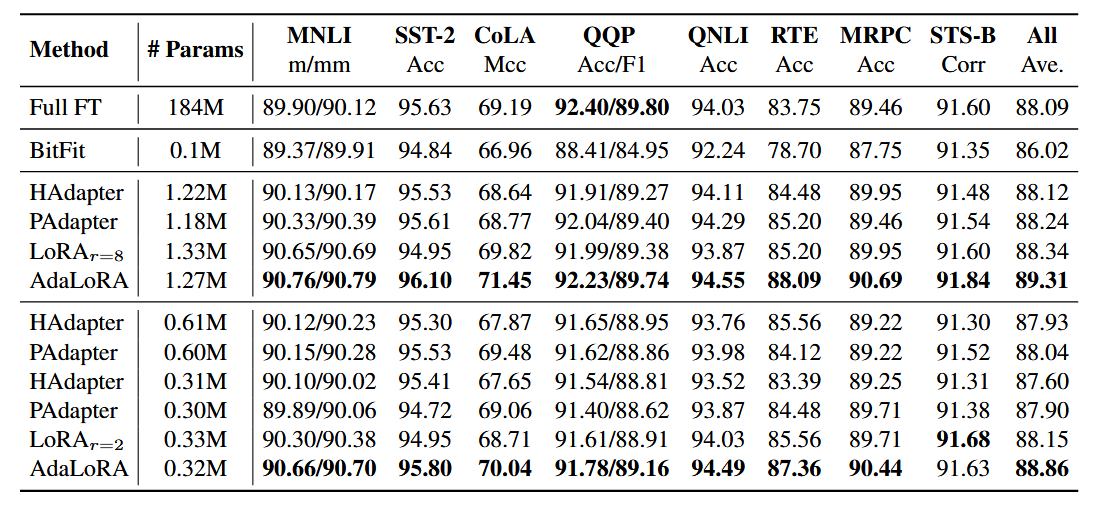

3. 评测指标
证明他的外推能力的评测指标。
看alibi等等评测指标。
lra。long range arena，benchmark。



In [1]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
model = AutoModelForCausalLM.from_pretrained("gpt2-medium")

加了lora之后：
GPT2LMModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (h): ModuleList(
      (0-23): 24 x Block(
        (ln_1): LayerNorm()
        (attn): Attention(
          (c_attn): MergedLinear(
            in_features=1024, out_features=3072, bias=True
            (lora_dropout): Dropout(p=0.1, inplace=False)
          )
          (c_proj): Conv1D()
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): GPT2LMHead(
    (decoder): Linear(in_features=1024, out_features=50257, bias=False)
  )
)

未加之前
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
(h): ModuleList(
      (0-23): 24 x Block(
        (ln_1): LayerNorm()
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

In [2]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout)

数据集
We evaluate the effectiveness of the proposed algorithm on natural language understanding (GLUE, Wang et al. (2019)), question answering (SQuADv1, Rajpurkar et al. (2016) and SQuADv2, Rajpurkar et al. (2018)), and natural language generation (XSum, Narayan et al. (2018) and CNN/DailyMail Hermann et al. (2015)).
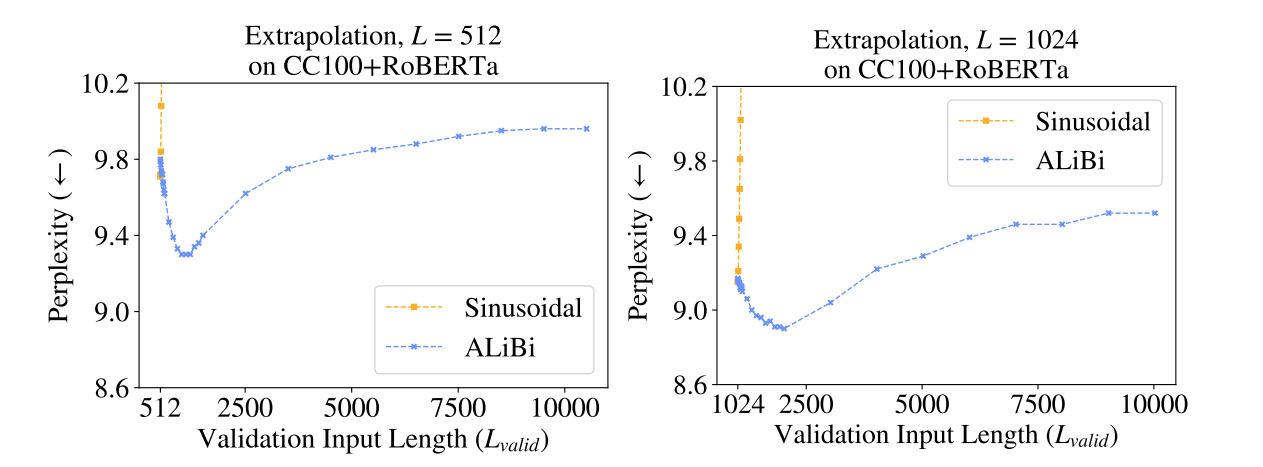

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
from typing import Optional, List
class LoRALayer():
    def __init__(
        self, 
        r: int, 
        lora_alpha: int, 
        lora_dropout: float,
        merge_weights: bool,
    ):
        self.r = r
        self.lora_alpha = lora_alpha
        # Optional dropout
        if lora_dropout > 0.:
            self.lora_dropout = nn.Dropout(p=lora_dropout)
        else:
            self.lora_dropout = lambda x: x
        # Mark the weight as unmerged
        self.merged = False
        self.merge_weights = merge_weights

class MergedLinear_pos(nn.Linear, LoRALayer):
    # LoRA implemented in a dense layer
    def __init__(
        self, 
        in_features: int, 
        out_features: int, 
        r: int = 0, 
        lora_alpha: int = 1, 
        lora_dropout: float = 0.,
        enable_lora: List[bool] = [False],
        fan_in_fan_out: bool = False,
        merge_weights: bool = True,
        **kwargs
    ):
        nn.Linear.__init__(self, in_features, out_features, **kwargs)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
                           merge_weights=merge_weights)
        assert out_features % len(enable_lora) == 0, \
            'The length of enable_lora must divide out_features'
        self.enable_lora = enable_lora
        self.fan_in_fan_out = fan_in_fan_out
        # Actual trainable parameters
        if r > 0 and any(enable_lora):
            self.lora_A = nn.Parameter(
                self.weight.new_zeros((r * sum(enable_lora), in_features)))
            self.lora_B = nn.Parameter(
                self.weight.new_zeros((out_features // len(enable_lora) * sum(enable_lora), r))
            ) # weights for Conv1D with groups=sum(enable_lora)
            self.scaling = self.lora_alpha / self.r
            # Freezing the pre-trained weight matrix
            self.weight.requires_grad = False
            # Compute the indices
            self.lora_ind = self.weight.new_zeros(
                (out_features, ), dtype=torch.bool
            ).view(len(enable_lora), -1)
            self.lora_ind[enable_lora, :] = True
            self.lora_ind = self.lora_ind.view(-1)
        self.reset_parameters()
        if fan_in_fan_out:
            self.weight.data = self.weight.data.transpose(0, 1)

    def reset_parameters(self):
        nn.Linear.reset_parameters(self)
        if hasattr(self, 'lora_A'):
            # initialize A the same way as the default for nn.Linear and B to zero
            nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            nn.init.zeros_(self.lora_B)

    def zero_pad(self, x):
        result = x.new_zeros((len(self.lora_ind), *x.shape[1:]))
        result[self.lora_ind] = x
        return result

    def merge_AB(self):
        def T(w):
            return w.transpose(0, 1) if self.fan_in_fan_out else w
        delta_w = F.conv1d(
            self.lora_A.unsqueeze(0), 
            self.lora_B.unsqueeze(-1), 
            groups=sum(self.enable_lora)
        ).squeeze(0)
        return T(self.zero_pad(delta_w))

    def train(self, mode: bool = True):
        def T(w):
            return w.transpose(0, 1) if self.fan_in_fan_out else w
        nn.Linear.train(self, mode)
        if mode:
            if self.merge_weights and self.merged:
                # Make sure that the weights are not merged
                if self.r > 0 and any(self.enable_lora):
                    self.weight.data -= self.merge_AB() * self.scaling
                self.merged = False
        else:
            if self.merge_weights and not self.merged:
                # Merge the weights and mark it
                if self.r > 0 and any(self.enable_lora):
                    self.weight.data += self.merge_AB() * self.scaling
                self.merged = True        

    def forward(self, x: torch.Tensor):
        def T(w):
            return w.transpose(0, 1) if self.fan_in_fan_out else w
        if self.merged:
            return F.linear(x, T(self.weight), bias=self.bias)
        else:
            result = F.linear(x, T(self.weight), bias=self.bias)
            if self.r > 0:
                result += self.lora_dropout(x) @ T(self.merge_AB().T) * self.scaling
            return result